# This notebook implements the BILP-Q tutorial in Cirq

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq
import cirq_google
from Utils_CSG import *
import sympy 
import numpy as np
from typing import Sequence, Tuple
from cirq.circuits import InsertStrategy
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

## Starting with the a given CSG
Using the same steps as in the BILP-Q Qiskit tutorial to generate the Q-matrix

In [2]:
coalition_values={
    '1':30,
    '2':40,
    '3':25,
    '1,2':70,
    '1,3':60,
    '2,3':65,
    '1,2,3':90
}
coalition_values

{'1': 30, '2': 40, '3': 25, '1,2': 70, '1,3': 60, '2,3': 65, '1,2,3': 90}

In [3]:
c,S,b = convert_to_BILP(coalition_values)       # A function in Utils_CSG.py
print(f'c = {c}\nS = {S}\nb = {b}')

c = [30, 40, 25, 70, 60, 65, 90]
S = [[1, 0, 0, 1, 1, 0, 1], [0, 1, 0, 1, 0, 1, 1], [0, 0, 1, 0, 1, 1, 1]]
b = [1, 1, 1]


In [4]:
qubo_penalty = 50 * -1

linear,quadratic = get_QUBO_coeffs(c,S,b,qubo_penalty)        # A function in Utils_CSG.py

print(f"Linear Coefficients = {linear} \n Quadratic Coefficients = {quadratic}")

Linear Coefficients = {'x_6': -240.0, 'x_3': -170.0, 'x_4': -160.0, 'x_5': -165.0, 'x_0': -80.0, 'x_1': -90.0, 'x_2': -75.0} 
 Quadratic Coefficients = {('x_3', 'x_6'): 200.0, ('x_4', 'x_6'): 200.0, ('x_5', 'x_6'): 200.0, ('x_0', 'x_3'): 100.0, ('x_0', 'x_4'): 100.0, ('x_0', 'x_6'): 100.0, ('x_1', 'x_3'): 100.0, ('x_1', 'x_5'): 100.0, ('x_1', 'x_6'): 100.0, ('x_2', 'x_4'): 100.0, ('x_2', 'x_5'): 100.0, ('x_2', 'x_6'): 100.0, ('x_3', 'x_4'): 100.0, ('x_3', 'x_5'): 100.0, ('x_4', 'x_5'): 100.0}


In [5]:
Q = np.zeros([len(linear),len(linear)])

#diagonal elements
for key,value in linear.items():
    Q[int(key.split('_')[1]),int(key.split('_')[1])] = value

#non diagonal elements
for key,value in quadratic.items():
    Q[int(key[0].split('_')[1]),int(key[1].split('_')[1])] = value/2
    Q[int(key[1].split('_')[1]),int(key[0].split('_')[1])] = value/2

Q = Q/240
Q.round(1)


array([[-0.3,  0. ,  0. ,  0.2,  0.2,  0. ,  0.2],
       [ 0. , -0.4,  0. ,  0.2,  0. ,  0.2,  0.2],
       [ 0. ,  0. , -0.3,  0. ,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0. , -0.7,  0.2,  0.2,  0.4],
       [ 0.2,  0. ,  0.2,  0.2, -0.7,  0.2,  0.4],
       [ 0. ,  0.2,  0.2,  0.2,  0.2, -0.7,  0.4],
       [ 0.2,  0.2,  0.2,  0.4,  0.4,  0.4, -1. ]])

## Initializing the circuit

There are many other ways to create circuts. Worth mentioning is that cirq can also create grid-circuits and check, whether all two-qubits gates are only applied to adjacent qubits. This can be usefull when implementing for real quantum devices (D-Wave part).

In [6]:
def cirq_init(n_prob):
    """Initializes a circuit of n_prob Line Qubits in equal superposition
    Return: the circuit itself and the quibits used in it"""
    circuit = cirq.Circuit() #initializing a circuit object
    qubits = cirq.LineQubit.range(n_prob) # creating n_prob qubits
    circuit.append(cirq.H(q) for q in qubits) # adding the just created qubits each with a H-Gate to the circuit
    return circuit, qubits

## Creating cost and mixer layers

In [7]:
# the mixer layer should just be a list of X rotation gates with parameter beta on each qubit
# that will be appended to the circuit

def mixer(in_circuit, beta_value: float):
    """Adds a mixer layer to circuit with parameter beta_value"""
    circuit = in_circuit.copy() 
    # without copy() circuit would still be the same instance of in_circuit
    # and mixer() would in-place change in_circuit
    
    n_qubits = len(circuit.get_independent_qubit_sets())
    circuit.append([cirq.X(q) ** beta_value for q in qubits],  strategy=InsertStrategy.NEW_THEN_INLINE)
    # adding an X-gate to the power of beta_value to every qubit. Using an insert strategy to put them all in the same moment
    # for better readability in the diagram later
    return circuit

In [8]:
def cost(in_circuit:cirq.circuits.circuit.Circuit, gamma_value:float, Q:np.ndarray) -> cirq.circuits.circuit.Circuit:
    """Adds the cost layer defined by QUBO matrix Q to circuit with the parameter gamma_value"""
    
    
    circuit = in_circuit.copy()
    nrow = np. size(Q, 0)
    ncol = np. size(Q, 1)
    
    # in the Q matrix, diagonal entries represent the coefficients for linear terms, while the of-diagonal non-zero elements
    # are the coefficients for mixed terms. A linear term will be implemented as Z rotation gate on the resprective qubit,
    # while a mixed term is implemented as ZZ rotational gate on the 2 resprective qubits.
    # the rotations are parametrized by the gamma_value for this sprecific layer
    
    for row in range(nrow):
        # we don't need to iterrate through the whole matrix, since it's symetrical. The upper right part and diagonal is enough
        for col in range(row, ncol):
            
            if row == col:
                lin = Q[row,col]
                continue 
                # if the element is on the diagonal we will collect the coefficient to apply the single Z gate after all
                # ZZ gates are done on this qubit
            
            elif Q[row,col] != 0:
                # when we have a non-diagonal element that is not zero we append a gama_value
                # parametrized ZZ rotation gate on the resprective 2 qubits
                circuit.append(cirq.ZZ(qubits[row],qubits[col]) ** (gamma_value * Q[row,col]))
        # the single qubit z gate for linear terms at the end of all ZZ gate for this qubit 
        if lin != 0:
            circuit.append(cirq.Z(qubits[row]) ** (gamma_value * lin))
                  
    return circuit

In [9]:
def cost(in_circuit:cirq.circuits.circuit.Circuit, gamma_value:float, Q:np.ndarray) -> cirq.circuits.circuit.Circuit:
    """Adds the cost layer defined by QUBO matrix Q to circuit with the parameter gamma_value"""
    
    
    circuit = in_circuit.copy()
    nrow = np. size(Q, 0)
    ncol = np. size(Q, 1)
    
    # in the Q matrix, diagonal entries represent the coefficients for linear terms, while the of-diagonal non-zero elements
    # are the coefficients for mixed terms. A linear term will be implemented as Z rotation gate on the resprective qubit,
    # while a mixed term is implemented as ZZ rotational gate on the 2 resprective qubits.
    # the rotations are parametrized by the gamma_value for this sprecific layer
    
    for row in range(nrow):
        # we don't need to iterrate through the whole matrix, since it's symetrical. The upper right part and diagonal is enough
        for col in range(row, ncol):
            
            if row == col:
                lin = Q[row,col]
                continue 
                # if the element is on the diagonal we will collect the coefficient to apply the single Z gate after all
                # ZZ gates are done on this qubit
            
            elif Q[row,col] != 0:
                # when we have a non-diagonal element that is not zero we append a gama_value
                # parametrized ZZ rotation gate on the resprective 2 qubits
                circuit.append(cirq.ZZ(qubits[row],qubits[col]) ** (gamma_value))
        # the single qubit z gate for linear terms at the end of all ZZ gate for this qubit 
        if lin != 0:
            circuit.append(cirq.Z(qubits[row]) ** (gamma_value * 0.5))
                  
    return circuit

## Creating the circuit
Note: the layer-functions still change the circuit in-place

In [10]:
p = 1 # number of layers

# Parameters are introduced as 'symbols'. Symbols can be used like variables in a circuit but need to be 'resolved'
# (get a value assigned to) when we want to simulate or run the circuit
beta = [sympy.Symbol("β_"+str(i)) for i in range(p)]
gamma = [sympy.Symbol("γ_"+str(i)) for i in range(p)]
print(beta, gamma)

[β_0] [γ_0]


In [11]:
problem_size = len(Q[0]) # defines how many qubits will be necessary to represent the problem 

qaoa, qubits = cirq_init(problem_size)

param_dict = {} #used to store the parameters in a dictionary. For later use in the param resolver
for i in range(p):
    qaoa = cost(qaoa, gamma[i], Q)
    qaoa = mixer(qaoa, beta[i])
    param_dict[gamma[i]] = 1
    param_dict[beta[i]] = 1
    
param_dict

{γ_0: 1, β_0: 1}

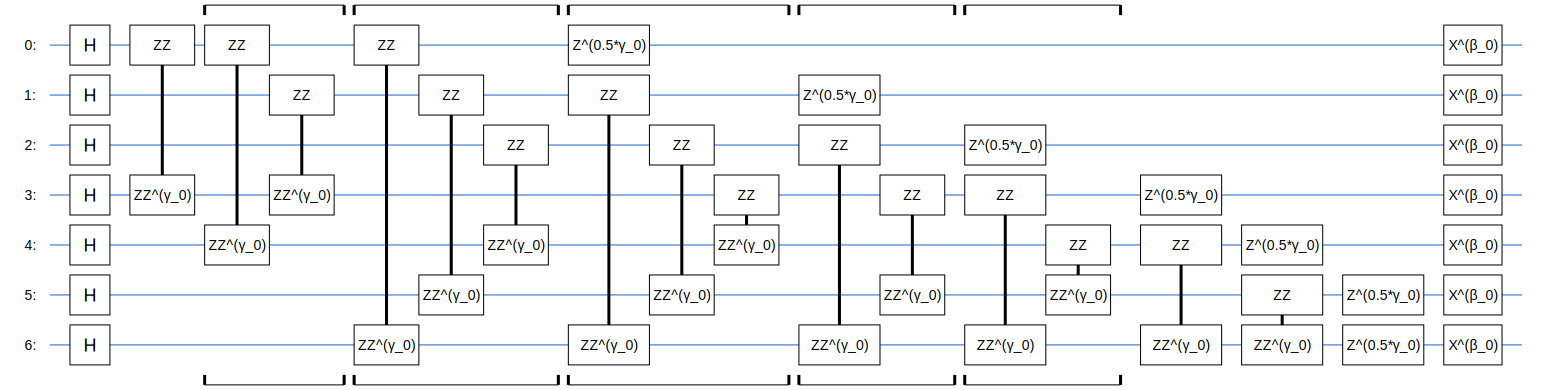

In [12]:
# better printing with SVG
SVGCircuit(qaoa)

In [13]:
def state_vector_params(gamma, beta, circuit):
    simulator = cirq.Simulator() # initializing the simulator object
    params = cirq.ParamResolver({"γ_0": gamma, "β_0": beta}) 
    #the param resolver maps values from the function input to the respective variables in the circuit
    
    result = abs(simulator.simulate(circuit, param_resolver=params).final_state_vector)
    # simulates the final state vector of the circuit with the input values for the parameters gamma and beta
    # only take tha absolut values since the imaginary parts should only exist due to rounding errors
    sum = 0
    for elm in result:
        sum += elm**2
    if 1 != round(sum,3):
        print("Warning: final state vector is normalized. Difference to 1 is more than .001")
    
    return result
 


# Numerical tests

In [14]:
def M_z(dim):
    """generic measurment operator in the computational basis
    dim: number of qubits in the circuit"""
    mat_Z = np.eye(2)
    mat_Z[1,1] = -1
    M = [1]
    for i in range(dim):
        M = np.kron(M, mat_Z)
    return M

M_z(3)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0., -0.,  0., -0.,  0., -0.],
       [ 0.,  0., -1., -0.,  0.,  0., -0., -0.],
       [ 0., -0., -0.,  1.,  0., -0., -0.,  0.],
       [ 0.,  0.,  0.,  0., -1., -0., -0., -0.],
       [ 0., -0.,  0., -0., -0.,  1., -0.,  0.],
       [ 0.,  0., -0., -0., -0., -0.,  1.,  0.],
       [ 0., -0., -0.,  0., -0.,  0.,  0., -1.]])

Creating the measurement operator for the expectation calculation 

In [15]:
def ez_filter(n, dim):
    '''
    Creates matrices like Z_n (for n={1,...,#qubits}) , where we apply the Z gate to the first Qubit for a circuit of dim number of qubits
    '''
    # start with Pauli-Z matrix
    ez_f = np.eye(2)
    ez_f[1,1] = -1

    if n == 1:
        #with for Z_1 we need to do the tensor product of Pauli-Z with dim-1 unit matrices
        ez_f = np.kron(ez_f, np.eye(2**(dim-1) ))
        
    else:
        #for Z_n we need a tensor product of n-1 unit matrices then Pauli-Z and again unit matrices for all the other qubits
        ez_f = np.kron(np.eye(2**(n-1)), ez_f)
        ez_f = np.kron(ez_f, np.eye(2**(dim-n)))   

    return ez_f

def m_op(Q):
    dim = len(Q[1])
    
    nrow = np. size(Q, 0)
    
    ncol = np. size(Q, 1)
        
    ez = np.zeros((2**nrow, 2**ncol))

    for row in range(nrow):
        
        for col in range(row, ncol):
            
            if row == col:
                lin = Q[row,col]
               
                continue 


            elif Q[row,col] != 0:
               
                ez += Q[row,col] * ez_filter(row+1, dim) @ ez_filter(col+1, dim)


        if lin != 0:
            ez += lin * ez_filter(row+1, dim)

        
    return ez



In [16]:
M = m_op(Q)
M= M_z(7)
#defines the measurement operator C(z) in 

In [17]:
grid_size = 40
gamma_max = 5
beta_max = 2

# Do the grid search.
energies = np.zeros((grid_size, grid_size))
for i in range(0,grid_size):
    for j in range(0,grid_size):
        vec = state_vector_params(i * gamma_max / grid_size, j * beta_max / grid_size, qaoa)
        energies[i, j] = vec @ M @ vec
        

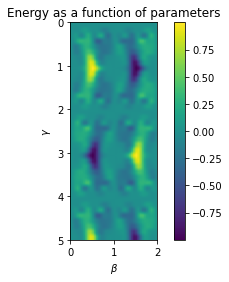

Numerically found parameters: Gamma = 1.0, Beta = 1.5
Energy = -0.9999997615814351


In [18]:
"""Plot the energy as a function of the parameters 𝛄 and β found in the grid search."""
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
plt.title("Energy as a function of parameters")
plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
plt.colorbar()
plt.show()
ind = np.unravel_index(np.argmin(energies, axis=None), energies.shape) 
ind_gam, ind_bet = ind
eng = energies[ind]
opt_gam = ind_gam / grid_size * gamma_max
opt_bet = ind_bet / grid_size * beta_max
print(f"Numerically found parameters: Gamma = {opt_gam}, Beta = {opt_bet}\nEnergy = {eng}")

There seems to be a symetry for beta and gamma. 
beta (0,2] and gama (0,5] seem to include all possible values.
For beta this seems obvious as it is only uses for rotational X-gates

In [19]:
# Adding a measurement layer
measure_qoao = qaoa.copy()
measure_qoao.append(cirq.measure(qubits, key = 'result'))

In [20]:
num_reps = 1000
params = cirq.ParamResolver({'γ_0': opt_gam, 'β_0': opt_bet})
simulator = cirq.Simulator()
measure_result = simulator.run(measure_qoao, param_resolver=params, repetitions = num_reps)

In [21]:
counts = measure_result.histogram(key='result')
common_solution = counts.most_common(3)
counts.most_common(10)

[(1, 1000)]

Not much of a clear winner in terms of probability. Still 127 is not the correct solution.

# Analytical optimization

In [22]:
# Basic gradient descent to find the best parameter for the lowest energy level
def param_optimizer(param_dict, circuit, qubits, lr, epochs):
    """param_dict: dictionary with parameters {γ_0: 0, β_0: 0, .... }
       returns one step optimimized parameter dictionary
    """
    # Creating the meassurement operator
    
    
    # setting up some utilities
    opt_energy = float('inf')
    opt_param_dict = {}
    simulator = cirq.Simulator() # initializing the simulator object
    params = cirq.ParamResolver(param_dict)
    
    random_restart = 0
    
    
    
    for step in range(epochs):
        
        # The final state vector and energy of the circuit with the parameter values given by param_dict
        base_state = abs(simulator.simulate(circuit, param_resolver=params).final_state_vector)
        base_energy = base_state @ M @ base_state
        
        # whenever the energy is lower than previously detected, the best value and it's parameter will be stored
        if base_energy < opt_energy: 
            opt_energy = base_energy
            opt_param_dict = param_dict
        
        # Calculating the gradient numerically    
        grad = np.zeros(len(param_dict))
        j = 0
        for i in param_dict:

            param_dict[i] += 0.001
            params = cirq.ParamResolver(param_dict)
            eps_state = abs(simulator.simulate(circuit, param_resolver=params).final_state_vector)
            param_dict[i] -= 0.001
            eps = base_energy - (eps_state @ M @ eps_state)
            grad[j] = eps/0.001
            j += 1

        grad = grad * lr
        
        j = 0
        for i in param_dict:
            param_dict[i] += grad[j]
            j +=1
        
        # the energy of the learned state = base state + gradient * learning rate
        params = cirq.ParamResolver(param_dict) # new parameter after the gradient step 
        vec = abs(simulator.simulate(circuit, param_resolver=params).final_state_vector)
        energy = vec @ M @ vec #energy after the gradient step
        if energy < opt_energy:
            opt_energy = energy
            opt_param_dict = param_dict
        else: 
            random_restart +=1
        
        if random_restart == 3:
            random_restart = 0
            param_dict[gamma[0]] = random.uniform(0, 5)
            param_dict[beta[0]] = random.uniform(0, 2)
        if not step % 25:    
            print(f"Epoch {step+1}, Energy: {opt_energy}")
    return opt_param_dict, opt_energy


In [23]:
solutions = []
param_dict[gamma[0]] = 0.3
param_dict[beta[0]] = 0.4
print(param_dict)

solutions.append(param_optimizer(param_dict, qaoa, qubits, 0.01, 300))
solutions

{γ_0: 0.3, β_0: 0.4}
Epoch 1, Energy: 0.2655149536164556
Epoch 26, Energy: -0.42596817444465096
Epoch 51, Energy: -0.6738208675667412
Epoch 76, Energy: -0.9957288514325419
Epoch 101, Energy: -0.9999914629821319
Epoch 126, Energy: -0.9999914629821319
Epoch 151, Energy: -0.9999914629821319
Epoch 176, Energy: -0.9999914629821319
Epoch 201, Energy: -0.9999914629821319
Epoch 226, Energy: -0.9999914629821319
Epoch 251, Energy: -0.9999914629821319
Epoch 276, Energy: -0.9999914629821319


[({γ_0: 3.047810649559125, β_0: 1.17182203207629}, -0.9999914629821319)]

In [24]:
opt_params = dict()
opt_params = solutions[0][0]

opt_params

{γ_0: 3.047810649559125, β_0: 1.17182203207629}

cirq.ParamResolver({sympy.Symbol('γ_0'): 3.047810649559125, sympy.Symbol('β_0'): 1.17182203207629})


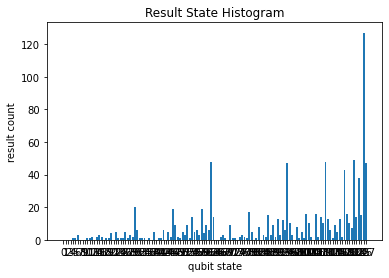

[(126, 127),
 (122, 49),
 (62, 48),
 (110, 48),
 (127, 47),
 (94, 47),
 (118, 43),
 (124, 38),
 (30, 20),
 (46, 19)]

In [25]:
num_reps = 1000
params = cirq.ParamResolver(opt_params)
print(params)
measure_result = simulator.run(measure_qoao, param_resolver=params, repetitions = num_reps)
  
cirq.plot_state_histogram(measure_result, plt.subplot())
plt.show()
counts = measure_result.histogram(key='result')
solution = counts.most_common(10)
solution